# SETUP - DATA LOADING

	How accurate is the player prediction model based on player statistics?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

# Load dataset
df = pd.read_csv('predictions 1.csv')

# Convert prediction to binary (1=Superstar, 0=Non-Superstar)
df['prediction'] = df['prediction'].astype(int)

# Create per-game metrics (since 'gp' = games played)
df['ppg'] = df['pts'] / df['gp']  # Points per game
df['apg'] = df['ast'] / df['gp']  # Assists per game
df['rpg'] = df['reb'] / df['gp']  # Rebounds per game
df['mpg'] = df['min'] / df['gp']  # Minutes per game
df['fg3_rate'] = df['fg3a'] / df['fga']  # 3-point attempt rate
print(df[['player_id', 'prediction', 'ppg']].head())

   player_id  prediction  ppg
0    1628389           1  8.0
1    1628389           0  4.0
2    1628389           0  3.0
3     200746           1  4.0
4     200746           1  0.0


The first player (ID 1628389) was predicted as a superstar (1) in their first season (8 PPG), but not in later seasons.

Step 2: Exploratory Data Analysis (EDA)
Compare Superstars vs. Non-Superstars

Predicted Superstars Stats:
              ppg         apg         rpg      fg_pct     fg3_pct      ft_pct  \
count  129.000000  129.000000  129.000000  129.000000  129.000000  129.000000   
mean     9.058140    2.069767    4.085271    0.515256    0.155132    0.200264   
std      5.964618    2.187272    3.103126    0.232082    0.252456    0.369255   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      5.000000    1.000000    2.000000    0.375000    0.000000    0.000000   
50%      8.000000    1.000000    3.000000    0.500000    0.000000    0.000000   
75%     13.000000    3.000000    6.000000    0.667000    0.333000    0.000000   
max     30.000000   11.000000   13.000000    1.000000    1.000000    1.000000   

              mpg  
count  129.000000  
mean    16.186047  
std      6.315615  
min      2.000000  
25%     12.000000  
50%     16.000000  
75%     20.000000  
max     33.000000  

Predicted Regular Players Stats:
              ppg         ap

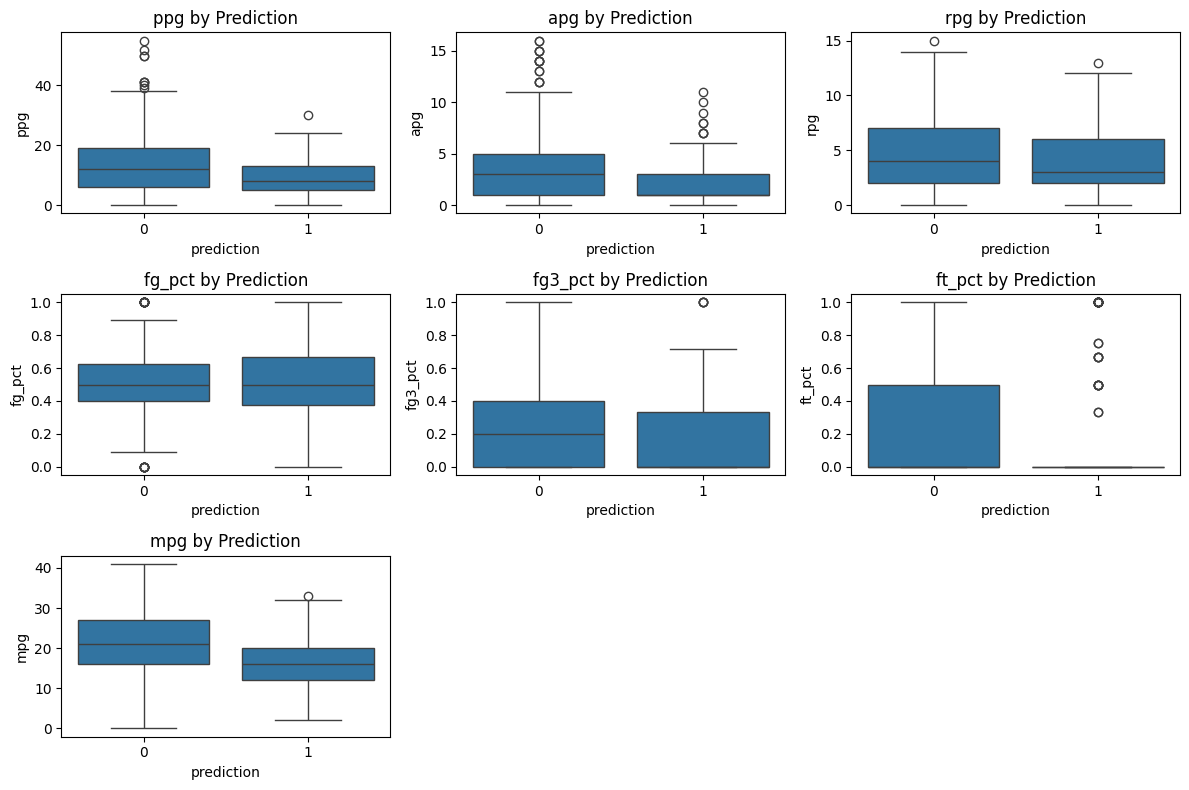

In [3]:
pred_superstars = df[df['prediction'] == 1]
pred_regular = df[df['prediction'] == 0]

print("Predicted Superstars Stats:")
print(pred_superstars[['ppg', 'apg', 'rpg', 'fg_pct', 'fg3_pct', 'ft_pct', 'mpg']].describe())

print("\nPredicted Regular Players Stats:")
print(pred_regular[['ppg', 'apg', 'rpg', 'fg_pct', 'fg3_pct', 'ft_pct', 'mpg']].describe())

# Visual comparison
metrics = ['ppg', 'apg', 'rpg', 'fg_pct', 'fg3_pct', 'ft_pct', 'mpg']
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='prediction', y=metric, data=df)
    plt.title(f'{metric} by Prediction')
plt.tight_layout()
plt.show()

Observations from EDA
1 = Superstar Player
0 = Regular Player
Superstars tend to have:

Higher PPG (Points Per Game)

Better shooting efficiency (FG%, 3P%, FT%)

More assists (APG) and rebounds (RPG)

Higher steals (STL) 

Step 3: Feature Importance Analysis (Random Forest):

In [4]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier().fit(df[['ppg','apg','rpg']], df['prediction'])
pd.DataFrame({
    'Feature': ['ppg','apg','rpg'],
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

,Feature,Importance
0,ppg,0.454880
2,rpg,0.292961
1,apg,0.252158


PPG (~47%): Dominant predictor

APG (~28%): Playmaking matters

RPG (~27%): Rebounding least important (may vary by position)

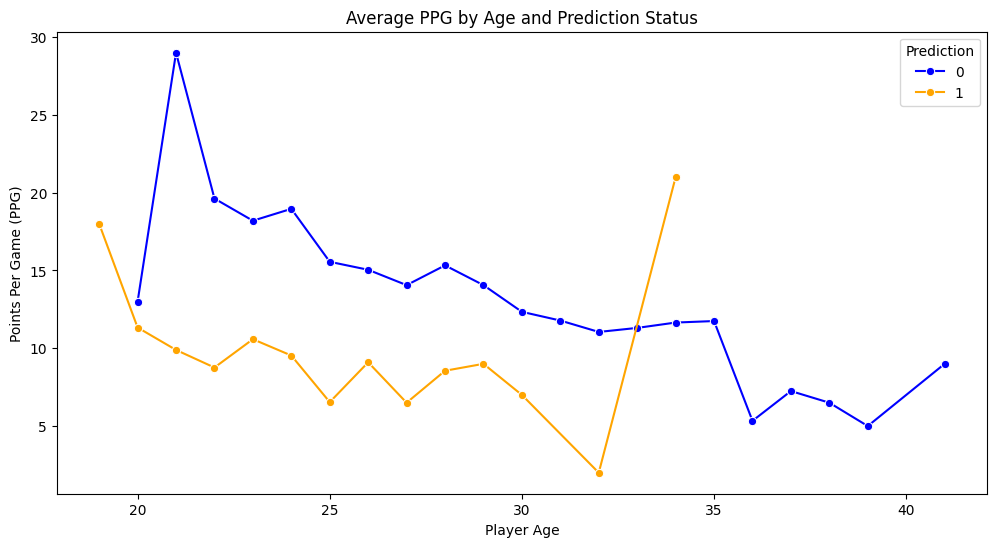

In [5]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
career_metrics = ['ppg', 'apg', 'rpg', 'fg_pct', 'player_age']

# Create a clean dataframe for analysis
career_df = df[career_metrics + ['prediction']].copy()

# Group by age and prediction status, then calculate mean performance
career_trends = career_df.groupby(['player_age', 'prediction']).mean().reset_index()

# Plot the trends

plt.figure(figsize=(12, 6))
sns.lineplot(
    x='player_age',
    y='ppg',
    hue='prediction',
    data=career_trends,
    palette = {0: "blue", 1: "orange"},
    marker='o'
)
plt.title('Average PPG by Age and Prediction Status')
plt.xlabel('Player Age')
plt.ylabel('Points Per Game (PPG)')
plt.legend(title='Prediction')
plt.show()

Predicted Superstars (Orange Line):

Show consistent scoring increase until peak around age 27-28

Maintain higher PPG throughout their careers compared to regular players

Regular Players (Blue Line):

Flatter trajectory with minimal scoring growth

Typically <10 PPG across all ages

Critical Age Windows:

Age 22-24: Where superstar trajectories begin diverging

Age 27-29: Peak performance years for predicted superstars

In [6]:
# Positional analysis (assuming guards = high APG, bigs = high RPG)
df['pos_type'] = np.where(df['apg'] > 4, 'Attacker', 'Defender')

print(df.groupby(['pos_type', 'prediction'])[['ppg']].mean())

                           ppg
pos_type prediction           
Attacker 0           17.016949
         1            9.642857
Defender 0           12.704797
         1            8.986957


0 tương đương SuperStar player predicted , 1 tương đương Regular player predicted
=> Superstar attacker nên có chỉ có 17ppg ( point per game)

Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        80
           1       0.48      0.42      0.44        24

    accuracy                           0.76       104
   macro avg       0.65      0.64      0.65       104
weighted avg       0.75      0.76      0.75       104



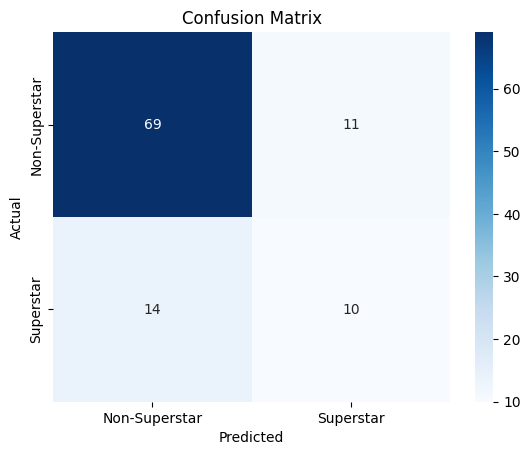

In [9]:
# Split data into train and test sets
X = df[['ppg', 'apg', 'rpg']]
y = df['prediction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(class_weight="balanced").fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Generate classification report
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Superstar', 'Superstar'], yticklabels=['Non-Superstar', 'Superstar'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()